## 1. Prepare data

In [1]:
import json
from collections import OrderedDict
from pprint import pprint

with open('/home/taeho/data/coco2014/annotations/annotations/instances_val2014.json', encoding="utf-8") as data_file:    
    data = json.load(data_file, object_pairs_hook=OrderedDict)

#pprint(data) #data는 json 전체를 dictionary 형태로 저장하고 있음

for i in range(0,50):
    image_id = data["images"][i]["id"]
    image_height = data["images"][i]["height"]
    image_width = data["images"][i]["width"]
    print("image_id =", image_id)
    
    for index, name in enumerate(data["annotations"]):
        category_id = name["category_id"]
        bbox = name["bbox"]
        
        if name["image_id"] == image_id:
            #print(name["image_id"])
            
            for index, name in enumerate(data["categories"]):
                
                if name["id"] == category_id:
                    #print(name["id"])
                    ##print(category_id, name["name"])
                    ##print(bbox)
                    pass

#for i in range(0,100):
#    print(data["categories"][i]["id"])
#    print(data["categories"][i]["name"])

image_id = 391895
image_id = 522418
image_id = 184613
image_id = 318219
image_id = 554625
image_id = 397133
image_id = 574769
image_id = 60623
image_id = 309022
image_id = 5802
image_id = 222564
image_id = 118113
image_id = 193271
image_id = 224736
image_id = 483108
image_id = 403013
image_id = 374628
image_id = 328757
image_id = 384213
image_id = 293802
image_id = 86408
image_id = 37777
image_id = 372938
image_id = 386164
image_id = 223648
image_id = 204805
image_id = 113588
image_id = 384553
image_id = 337264
image_id = 368402
image_id = 12448
image_id = 252219
image_id = 79841
image_id = 87038
image_id = 174482
image_id = 515289
image_id = 562150
image_id = 542145
image_id = 412151
image_id = 403385
image_id = 579003
image_id = 540186
image_id = 242611
image_id = 51191
image_id = 269105
image_id = 294832
image_id = 462565
image_id = 144941
image_id = 173350
image_id = 60760


## 2. Train

In [1]:
import os
import itertools
import torch

from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR

from utils.misc import str2bool, freeze_net_layers, store_labels

from ssd.ssd import MatchPrior
from ssd.vgg_ssd import create_vgg_ssd
from ssd.config import vgg_ssd_config
from ssd.data_preprocessing import TrainAugmentation, TestTransform

from datasets.COCO_dataset import COCODataset

from nn.multibox_loss import MultiboxLoss


print('Single Shot MultiBox Detector Training With Pytorch')

dataset_type = "COCO"
datasets = "/home/taeho/data/coco2014"
validation_dataset = "/home/taeho/data/coco2014"
net = "vgg16-ssd"

# Params for SGD
lr = 1e-3 #1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
base_net_lr = None
extra_layers_lr = None

# Params for loading pretrained basenet or checkpoints.
base_net = "models/vgg16_reducedfc.pth"
pretrained_ssd = None
resume = None

# Scheduler
scheduler = "multi-step"

# Params for Multi-step Scheduler
milestones = "120,160"

# Params for Cosine Annealing
t_max = 120.0

# Train params
batch_size = 16 #24
num_epochs = 2
num_workers = 4
validation_epochs = 5
debug_steps = 100
use_cuda = True
checkpoint_folder = 'models/'


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

if use_cuda and torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("Use Cuda.")


def train(loader, net, criterion, optimizer, device, debug_steps=100, epoch=-1):
    net.train(True)
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    
    for i, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        confidence, locations = net(images)
        
        regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)  # TODO CHANGE BOXES
        loss = regression_loss + classification_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
        
        if i and i % debug_steps == 0:
            running_loss = 0.0
            running_regression_loss = 0.0
            running_classification_loss = 0.0


def test(loader, net, criterion, device):
    net.eval()
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    num = 0
    
    for _, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)
        num += 1

        with torch.no_grad():
            confidence, locations = net(images)
            regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)
            loss = regression_loss + classification_loss

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
        
    return running_loss / num, running_regression_loss / num, running_classification_loss / num

    
if net == 'vgg16-ssd':
    create_net = create_vgg_ssd
    config = vgg_ssd_config
else:
    print("No network")
    
    
train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance,
                              config.size_variance, 0.5)

test_transform = TestTransform(config.image_size, config.image_mean, config.image_std)


print("Prepare training and validation datasets.")
datalist = []

if dataset_type == 'COCO':

    dataset = COCODataset(datasets, transform=train_transform,
                         target_transform=target_transform, is_test=False)
    val_dataset = COCODataset(validation_dataset, transform=test_transform,
                             target_transform=target_transform, is_test=True)
    
    label_file = os.path.join(checkpoint_folder, "coco-model-labels.txt")
    store_labels(label_file, dataset.class_names)
    num_classes = len(dataset.class_names)
    
    print("Stored labels into file coco-model-labels.txt.")
else:
    print("No dataset_type")


datalist.append(dataset)
train_dataset = ConcatDataset(datalist)

print("Train dataset size: {}". format(len(train_dataset)))
print("validation dataset size: {}".format(len(val_dataset)))

train_loader = DataLoader(train_dataset, batch_size,
                          num_workers=num_workers,
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size,
                        num_workers=num_workers,
                        shuffle=False)


print("Build network.")
net = create_net(num_classes)
min_loss = -10000.0
last_epoch = -1

base_net_lr = base_net_lr if base_net_lr is not None else lr
extra_layers_lr = extra_layers_lr if extra_layers_lr is not None else lr
    
params = [
            {'params': net.base_net.parameters(), 'lr': base_net_lr},
            {'params': itertools.chain(net.source_layer_add_ons.parameters(),
                                       net.extras.parameters()),
             'lr': extra_layers_lr},
            {'params': itertools.chain(net.regression_headers.parameters(),
                                       net.classification_headers.parameters())}
         ]


if resume:
    print("Resume from the model\n")
    net.load(resume)
elif base_net:
    print("Init from base net\n")
    net.init_from_base_net(base_net)
elif pretrained_ssd:
    print("Init from pretrained ssd\n")
    net.init_from_pretrained_ssd(pretrained_ssd)


net.to(DEVICE) #cuda

criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                         center_variance=0.1, size_variance=0.2, device=DEVICE)
optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum,
                            weight_decay=weight_decay)

print("Learning rate:", lr, "Base net learning rate:", base_net_lr,
      "Extra Layers learning rate:", extra_layers_lr)

if scheduler == 'multi-step':
    print("Uses MultiStepLR scheduler.")
    milestones = [int(v.strip()) for v in milestones.split(",")]
    scheduler = MultiStepLR(optimizer, milestones=milestones,
                            gamma=0.1, last_epoch=last_epoch)
elif scheduler == 'cosine':
    print("Uses CosineAnnealingLR scheduler.")
    scheduler = CosineAnnealingLR(optimizer, t_max, last_epoch=last_epoch)
else:
    print("Unsupported Scheduler")


print("Start training from epoch 0.\n")
for epoch in range(last_epoch + 1, num_epochs):
    scheduler.step()
    train(train_loader, net, criterion, optimizer,
          device=DEVICE, debug_steps=debug_steps, epoch=epoch)
        
    if epoch % validation_epochs == 0 or epoch == num_epochs - 1:
        val_loss, val_regression_loss, val_classification_loss = test(val_loader, net, criterion, DEVICE)
        
        print("Epoch:", epoch, "\n", 
              "Validation Loss:", val_loss, "\n",
              "Validation Regression Loss:", val_regression_loss, "\n",
              "Validation Classification Loss:", val_classification_loss
              )
        
        name = "vgg16-ssd" + "-Epoch-" + "%s"%epoch + "-Loss-" + "%s"%str(val_loss)[:7] + ".pth"
        model_path = os.path.join(checkpoint_folder, name)
        net.save(model_path)
        print("Saved model:", model_path, "\n")
        


Single Shot MultiBox Detector Training With Pytorch
Use Cuda.
Prepare training and validation datasets.
Stored labels into file coco-model-labels.txt.
Train dataset size: 24
validation dataset size: 24
Build network.
Init from base net

Learning rate: 0.001 Base net learning rate: 0.001 Extra Layers learning rate: 0.001
Uses MultiStepLR scheduler.
Start training from epoch 0.

Epoch: 0 
 Validation Loss: 43.81428337097168 
 Validation Regression Loss: 5.715577602386475 
 Validation Classification Loss: 38.09870719909668
Saved model: models/vgg16-ssd-Epoch-0-Loss-43.8142.pth 

Epoch: 1 
 Validation Loss: 28.753564834594727 
 Validation Regression Loss: 4.5066680908203125 
 Validation Classification Loss: 24.246896743774414
Saved model: models/vgg16-ssd-Epoch-1-Loss-28.7535.pth 



## 3. Eval
__'difficult':__


an object marked as 'difficult', indicates that the object is considered difficult to recognize,  
for example an object which is clearly visible but unidentifiable without substantial use of context.  
Objects marked as difficult are currently ignored in the evaluation of the challenge.

In [1]:
import pathlib
import numpy as np
import torch

from ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor

from datasets.COCO_dataset import COCODataset

from utils import box_utils, measurements
from utils.misc import str2bool


print("SSD Evaluation on COCO Dataset.")

net = "vgg16-ssd"
trained_model = "models/vgg16-ssd-Epoch-1-Loss-28.7535.pth"
dataset_type = "COCO"
dataset = "/home/taeho/data/coco2014"
label_file = "models/coco-model-labels.txt"
use_cuda = True
use_2007_metric = False # figure out: It computes average precision based on the definition of Pascal Competition.
nms_method = "hard"
iou_threshold = 0.5
eval_dir = "eval_results"


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")


def group_annotation_by_class(dataset):
    true_case_stat = {}
    all_gt_boxes = {}
    all_difficult_cases = {}
    for i in range(len(dataset)):
        image_id, annotation = dataset.get_annotation(i)
        gt_boxes, classes, is_difficult = annotation
        gt_boxes = torch.from_numpy(gt_boxes)
        for i, difficult in enumerate(is_difficult):
            class_index = int(classes[i])
            gt_box = gt_boxes[i]
            if not difficult:
                true_case_stat[class_index] = true_case_stat.get(class_index, 0) + 1

            if class_index not in all_gt_boxes:
                all_gt_boxes[class_index] = {}
            if image_id not in all_gt_boxes[class_index]:
                all_gt_boxes[class_index][image_id] = []
            all_gt_boxes[class_index][image_id].append(gt_box)
            if class_index not in all_difficult_cases:
                all_difficult_cases[class_index]={}
            if image_id not in all_difficult_cases[class_index]:
                all_difficult_cases[class_index][image_id] = []
            all_difficult_cases[class_index][image_id].append(difficult)

    for class_index in all_gt_boxes:
        for image_id in all_gt_boxes[class_index]:
            all_gt_boxes[class_index][image_id] = torch.stack(all_gt_boxes[class_index][image_id])
    for class_index in all_difficult_cases:
        for image_id in all_difficult_cases[class_index]:
            all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])
    return true_case_stat, all_gt_boxes, all_difficult_cases


def compute_average_precision_per_class(num_true_cases, gt_boxes, difficult_cases,
                                        prediction_file, iou_threshold, use_2007_metric):
    with open(prediction_file) as f:
        image_ids = []
        boxes = []
        scores = []
        
        for line in f:
            t = line.rstrip().split(" ")
            image_ids.append(t[0])
            scores.append(float(t[1]))
            box = torch.tensor([float(v) for v in t[2:]]).unsqueeze(0)
            box -= 0.0  # convert to python format where indexes start from 0
            boxes.append(box)
            
        scores = np.array(scores)
        sorted_indexes = np.argsort(-scores)
        boxes = [boxes[i] for i in sorted_indexes]
        image_ids = [image_ids[i] for i in sorted_indexes]
        true_positive = np.zeros(len(image_ids))
        false_positive = np.zeros(len(image_ids))
        matched = set()
        for i, image_id in enumerate(image_ids):
            box = boxes[i]
            if image_id not in gt_boxes:
                false_positive[i] = 1
                continue

            gt_box = gt_boxes[image_id]
            ious = box_utils.iou_of(box, gt_box)
            max_iou = torch.max(ious).item()
            max_arg = torch.argmax(ious).item()
            if max_iou > iou_threshold:
                if difficult_cases[image_id][max_arg] == 0:
                    if (image_id, max_arg) not in matched:
                        true_positive[i] = 1
                        matched.add((image_id, max_arg))
                    else:
                        false_positive[i] = 1
            else:
                false_positive[i] = 1

    true_positive = true_positive.cumsum()
    false_positive = false_positive.cumsum()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / num_true_cases
    
    if use_2007_metric:
        return measurements.compute_voc2007_average_precision(precision, recall)
    else:
        return measurements.compute_average_precision(precision, recall)


if __name__ == '__main__':
    
    eval_path = pathlib.Path(eval_dir)
    eval_path.mkdir(exist_ok=True)
    
    class_names = [name.strip() for name in open(label_file).readlines()]

    if dataset_type == "COCO":
        dataset = COCODataset(dataset, is_test=True)
    else:
        print("No dataset_type")

    true_case_stat, all_gb_boxes, all_difficult_cases = group_annotation_by_class(dataset)
    
    if net == 'vgg16-ssd':
        net = create_vgg_ssd(len(class_names), is_test=True)
        predictor = create_vgg_ssd_predictor(net, nms_method=nms_method, device=DEVICE)
    else:
        print("No net type")

    print("Load Model")
    net.load(trained_model)
    net = net.to(DEVICE)          
    
    
    results = []
    for i in range(len(dataset)):
        #if i == 0 or i == (len(dataset)-1):
        if (i == 0) or (i % 10 == 0) or (i == (len(dataset)-1)):
            print("process image", i)
            
        image = dataset.get_image(i)
        boxes, labels, probs = predictor.predict(image)
        indexes = torch.ones(labels.size(0), 1, dtype=torch.float32) * i
        results.append(torch.cat([indexes.reshape(-1, 1),
                                  labels.reshape(-1, 1).float(),
                                  probs.reshape(-1, 1),
                                  boxes + 0.0  # matlab's indexes start from 1
                                 ], dim=1))
        
    results = torch.cat(results)
    
    aps = []
    print("\nAverage Precision Per-class:\n")
    for class_index, class_name in enumerate(class_names):
        if class_index == 0:
            continue  # ignore background
            
        prediction_path = eval_path / f"det_test_{class_name}.txt"
        
        with open(prediction_path, "w") as f:
            sub = results[results[:, 1] == class_index, :]
            for i in range(sub.size(0)):
                prob_box = sub[i, 2:].numpy()
                image_id = dataset.ids[int(sub[i, 0])]
                print(image_id + " " + " ".join([str(v) for v in prob_box]), file=f)
        
        try:
            ap = compute_average_precision_per_class(true_case_stat[class_index],
                                                     all_gb_boxes[class_index],
                                                     all_difficult_cases[class_index],
                                                     prediction_path,
                                                     iou_threshold,
                                                     use_2007_metric)
        except KeyError:
            pass
        
        aps.append(ap)
        if ap > 1e-7: #exclude 0.0 ap
            print(f"{class_name}: {ap}")
    
    print(f"\nAverage Precision Across All Classes:{sum(aps)/len(aps)}")
    

SSD Evaluation on COCO Dataset.


/home/taeho/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Load Model
process image 0
process image 10
process image 20
process image 23

Average Precision Per-class:

person: 0.000407237262806498
bench: 0.001941747572815534
bird: 0.001941747572815534
cow: 0.00010364842454394692
elephant: 0.00010364842454394692
bear: 0.00010364842454394692
zebra: 0.00010364842454394692
giraffe: 0.00010364842454394692
bowl: 3.9178812098417176e-05
chair: 6.601967386281112e-05
couch: 6.601967386281112e-05
tv: 0.00021294718909710392
mouse: 0.00016559032952475575
remote: 0.00016559032952475575
microwave: 0.0014749262536873156
oven: 0.0006346909559402933
sink: 0.0019295900549914208

Average Precision Across All Classes:0.00011954409754683735


In [1]:
# sort dictionary by key
d = {2:3, 1:89, 4:5, 3:0}
dict(sorted(d.items(), reverse=True))

{4: 5, 3: 0, 2: 3, 1: 89}

## 4. Visualize

COCO_val2014_000000403013
Found 3 objects.


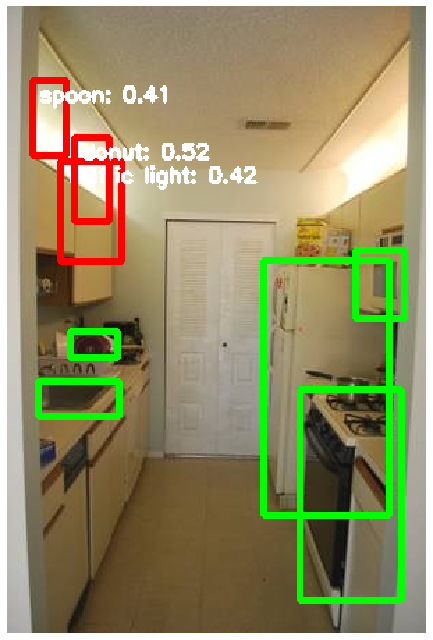

In [1]:
from ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor

import json
from collections import OrderedDict
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline


def image_print(how_many_images):
    
    net_type = "vgg16-ssd"
    model_path = "models/vgg16-ssd-Epoch-1-Loss-28.7535.pth"
    label_path = "models/coco-model-labels.txt"
    data_dir = "/home/taeho/data/coco2014/"
    test_txt = data_dir + "images/test.txt"

    class_names = [name.strip() for name in open(label_path).readlines()]
    image_names = [name.strip() for name in open(test_txt).readlines()]
    
    
    if how_many_images > len(image_names):
        print("Put number less than %d" %len(image_names))
        return
    elif how_many_images < 0:
        print("No negative number")
        return
    else:
        how_many_images = int(how_many_images)
    
    
    if net_type == 'vgg16-ssd':
        net = create_vgg_ssd(len(class_names), is_test=True)
        predictor = create_vgg_ssd_predictor(net, candidate_size=200)
    else:
        print("The net type is wrong.")

    
    net.load(model_path)

    
    nums = [x for x in range(len(image_names))]
    random.shuffle(nums)
    shuffled_nums = []
    for x in range(how_many_images):
        shuffled_nums.append(nums[x])
    image_names_part = []
    for num in shuffled_nums:
        image_names_part.append(image_names[num])


    for i, name in enumerate(image_names_part):
        image_path = data_dir + "images/val2014/" + image_names_part[i] + ".jpg"
        print(name)

        orig_image = cv2.imread(image_path)
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        boxes, labels, probs = predictor.predict(image, 10, 0.4)

        for i in range(boxes.size(0)):
            box = boxes[i, :]
            cv2.rectangle(orig_image, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 4)
            label = str(class_names[labels[i]]) + ": " + str(probs[i])[-7:-3]

            cv2.putText(orig_image, label,
                        (box[0] + 5, box[1] + 15),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,  # font scale
                        (255,255,255),
                        2)  # line type

        print(f"Found {len(probs)} objects.")

        
        annotation_file = data_dir + "annotations/annotations/instances_val2014.json"
        with open(annotation_file, encoding="utf-8") as data_file:
            data = json.load(data_file, object_pairs_hook=OrderedDict)

        boxes = []
        image_number = int(name[-6:])

        for index, name in enumerate(data["images"]):
            if name["id"] == image_number:
                image_height = name["height"]
                image_width = name["width"]
        for index, name in enumerate(data["annotations"]):
            category_id = name["category_id"]
            bbox = name["bbox"]
            if name["image_id"] == image_number:
                for index, name in enumerate(data["categories"]):
                    if name["id"] == category_id:

                        xmin = round(bbox[0])
                        if xmin == 0:
                            xmin += 1
                        ymin = round(bbox[1])
                        if ymin == 0:
                            ymin += 1
                        xmax = round(bbox[0] + bbox[2])
                        if xmax == image_width:
                            xmax -= 1
                        ymax = round(bbox[1] + bbox[3])
                        if ymax == image_height:
                            ymax -= 1

                        bbox = [xmin, ymin, xmax, ymax]
                        boxes.append(bbox)

        for i, num in enumerate(boxes):
            cv2.rectangle(orig_image, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), (0, 255, 0), 4)
            

        img = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(9,9))
        plt.axis('off')
        plt.xticks([]), plt.yticks([])
        plt.tight_layout()
        plt.imshow(img)
        plt.show()

        path = "run_ssd_example_output.jpg"
        ##cv2.imwrite(path, img)
        

image_print(1)